In [1]:
import jax.numpy as np
from BLEanalysis.signals import Signals
sigs = Signals("noamploc2long.log",'d',angleOffset = 38)

Standardising angles and times (shifting by 38.00 degrees)


In [5]:
import matplotlib.pyplot as plt
#from matplotlib_scalebar.scalebar import ScaleBar
from BLEanalysis.synthetic import SimpleDemo

class SignalDemo(SimpleDemo):
    def __init__(self,burst_length = 1500,sample_interval = 100):
        """
        Generate a synthetic burst for each observation, using the observations generated by "SimpleDemo" (parent class).
        Store as a list of dictionaries in self.observations
        """
        super().__init__()
        new_observations = []
        for obs in self.observations:
            synthetic_angle = np.arctan2(obs[3],obs[2])
            data_rssis,data_angles = sigs.getSample(burst_length, sample_interval,exclude_missing=20)
            new_obs = {'transmitter_position':obs[:2],'rssis':data_rssis,'angles':data_angles-synthetic_angle}
            
            new_observations.append(new_obs)
        self.burst_observations = new_observations

In [6]:
demo = SignalDemo()

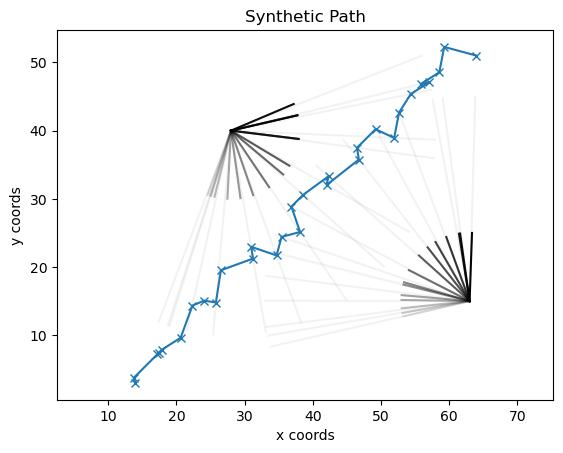

In [7]:
demo.plot()
for i,obs in enumerate(demo.burst_observations):
    lpdf,_,_,_ = angles.infer(obs['rssis'],obs['angles'])
    a = np.deg2rad(np.argmax(lpdf))
    x,y = obs['transmitter_position']
    plt.plot([x,x+np.cos(a)*10],[y,y+np.sin(a)*10],'k-',alpha=0.1+i/33)

In [10]:
from BLEanalysis.pathinference import Path
from BLEanalysis.angleinference import AnglesUsePatternMeans
from BLEanalysis.kernels import ExponentiatedQuadraticKernel
from jax.scipy.stats import norm
angles = AnglesUsePatternMeans(sigs)

class Path_ProbabilityDensitiesToBee(Path):
    def __init__(self, observation_times, burst_observations, kernel, noise_scale, inducing_points, ndims = 2):
        """Pass each burst as an observation"""
        super().__init__(observation_times, burst_observations, kernel, noise_scale, inducing_points, ndims)

    def prepare_likelihood(self):
        all_lpdfs = []
        all_ypos = []
        all_argmax_angles = []
        for i,obs in enumerate(self.y):
            lpdf,_,_,_ = angles.infer(obs['rssis'],obs['angles'])
            all_lpdfs.append(lpdf)
            all_ypos.append(obs['transmitter_position'])
            all_argmax_angles.append(np.deg2rad(np.argmax(lpdf)))
        self.y_vects = np.array(all_lpdfs)
        self.y_angles = np.array(all_argmax_angles)
        self.y_pos = np.array(all_ypos).T.reshape(len(self.y)*self.ndims)
        

    def compute_log_likelihood(self,samples):
        """
        Samples are possible locations of the bee. 
        Return an array of the loglikelihood of each.
        Assumes observations are angles to the bees.
        """
        print("!!")
        samples_with_z = np.c_[samples,np.zeros([self.number_samples,self.n])] #adds an extra axis
        s = samples_with_z.reshape(self.number_samples,3,self.n)
        s = np.swapaxes(s,1,2)      
        vects = np.c_[np.cos(self.y_angles),np.sin(self.y_angles)]
        cross_vects = np.cross(vects,s)
        distances = np.linalg.norm(cross_vects,axis=2) #don't need to divide by np.linalg.norm(y[:,2:],axis=1), as this is set to one
        return norm.logpdf(distances,0,0.1)


k = ExponentiatedQuadraticKernel(7.0,5.0)
path = Path_ProbabilityDensitiesToBee(demo.obstimes,demo.burst_observations,k,1.0,8)
path.run(200,learning_rate=5)

Optimising mean...
!!
!!
iteration    0: 1965782.6
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
iteration   50:   26509.7
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Optimising mean and covariance...
!!
!!
iteration    0:   12410.6
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
iteration   50:    7578.7
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!


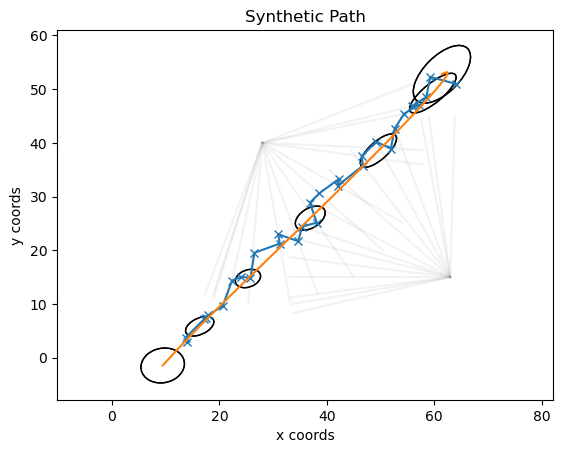

In [12]:
demo.plot()
path.plot()
